In [16]:
import numpy as np
import numpy.linalg as LA
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import sys 
sys.path.append("../")
from libs.create import create_norm_data, create_out_cov
from libs.functions import sigmoid, g_lo, g_up

n = 1000
m = 3*n
eps = 0.1
data_dim = 2
mu = 5
mu_out = 0
par_mu = np.full(data_dim, mu)
par_sd = np.eye(data_dim)
out_mu = np.full(data_dim, mu_out)
out_sd = np.eye(data_dim)
par_reg1 = 0.0005
par_reg2 = 0.0005
exper_iter = 3
optim_iter = 100
L = 1
learn_par = 0.05
dicay_par = 0.4
par_cov, out_cov = np.eye(data_dim), np.eye(data_dim)

In [17]:
# 分散を単位行列で固定
res_mean = [0 for i in range(exper_iter)]
res_par = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    print("%d/%d" %(i+1, exper_iter))
    data = create_norm_data(n, eps, par_mu, par_cov, out_mu, out_cov)
    mean_hist = []
    par_hist = []
    # 平均は次元ごとにロバスト、分散はロバストでない
    alpha = [np.median(data, axis=0), par_cov]
    z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)

    def discriminator(x, beta):
        size, data_dim = x.shape[0], x.shape[-1]
        stack = [x]
        value = np.dot(np.stack(stack, axis=1).reshape(size, len(stack)*data_dim),beta)
        return value
    size_par = data_dim

    # par = np.random.normal(loc = 0, scale = 0.1, size = size_par)
    par = alpha[0]
    bias = np.array(np.mean( discriminator(z, par[0:size_par]) ))[np.newaxis]
    par = np.concatenate([par, bias], axis = 0)
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1] , size = m)
        def major_func(par, past_par):
            new_beta = par[0:size_par]; new_b = par[size_par]; beta = past_par[0:size_par]; b = past_par[size_par]
            A = np.mean(g_lo(discriminator(z, new_beta) - new_b, discriminator(z, beta) - b))
            B = np.mean(g_up(discriminator(data, new_beta) - new_b, discriminator(data, beta) - b))
            reg = LA.norm(new_beta, ord=2)*par_reg1
            return -(A-B - reg)

        l = 0
        while(l<L):
            op = minimize(major_func, x0 = par, args = par)
            par = op.x
            l+=1
        
        alpha_m = alpha[0]; alpha_v = alpha[1]
        mgrad = ((z-alpha_m)[:, np.newaxis, :]).sum(axis=2)
        sig_ = sigmoid(discriminator(z, par[:size_par]) - par[size_par])[:,np.newaxis]
        tmp_alpha_m = alpha[0] - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        alpha[0] = tmp_alpha_m

        mean_hist.append(alpha[0])
        par_hist.append(par)
    res_mean[i] = mean_hist
    res_par[i] = par_hist


1/3


100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


2/3


100%|██████████| 100/100 [00:03<00:00, 30.68it/s]


3/3


100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


In [11]:
def plot_2dim(res, res_par,ylim = True):
    mu_result = np.array(res)
    nppar = np.array(res_par)
    num_graph_row = 5
    exper_iter = mu_result.shape[0]
    optim_iter = mu_result.shape[1]
    plt.figure(figsize=(4*num_graph_row,4*exper_iter))
    half = int(optim_iter/2)
    mean=[]
    for i in (range(exper_iter)):
        # mu
        plt.subplot(exper_iter,num_graph_row, num_graph_row*i +1)
        plt.title("estimaterd mu")
        # plt.ylim(4.75, 5.3)
        # plt.xlim(4.75, 5.3)
        plt.scatter(mu_result[i,:half,0], mu_result[i,:half,1], color = "m")
        plt.scatter(mu_result[i,half:,0], mu_result[i,half:,1], color = "c")
        plt.scatter(mu_result[i,0,0], mu_result[i,0,1], c="red")
        plt.scatter(mu_result[i,-1,0], mu_result[i,-1,1], c="blue")
        #plt.scatter(5, 5, color = "black")

        # par1 2
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +2)
        plt.title("parameter of u")
        plt.scatter(nppar[i,half:,0], nppar[i,half:,1], color = "c")
        plt.scatter(nppar[i,:half,0], nppar[i,:half,1], color = "m")
        plt.scatter(nppar[i,0,0], nppar[i,0,1], c="red")
        plt.scatter(nppar[i,-1,0], nppar[i,-1,1], c="blue")


        #loss of u norm
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +3)
        plt.title("l2 norm of u")
        if ylim:
            plt.ylim(0.2,0.8)
        loss = np.linalg.norm(nppar[i,:, :-1], ord = 2, axis=1)
        plt.plot(range(len(loss)), loss)   

        #bias
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +4)
        plt.title("bias")
        plt.plot(range(len(nppar[i,:,-1])), nppar[i,:, -1])       

        # loss of mu
        plt.subplot(exper_iter, num_graph_row, num_graph_row*i +5)
        plt.title("l2 loss")
        if ylim:
            plt.ylim(0,0.2)
        loss = np.linalg.norm(mu_result[i]-par_mu, ord = 2, axis=1)
        mean.append(loss[-1])
        plt.plot(range(len(loss)), loss)
    print("average mean is : %.4f"%np.mean(mean))

average mean is : 1.1405


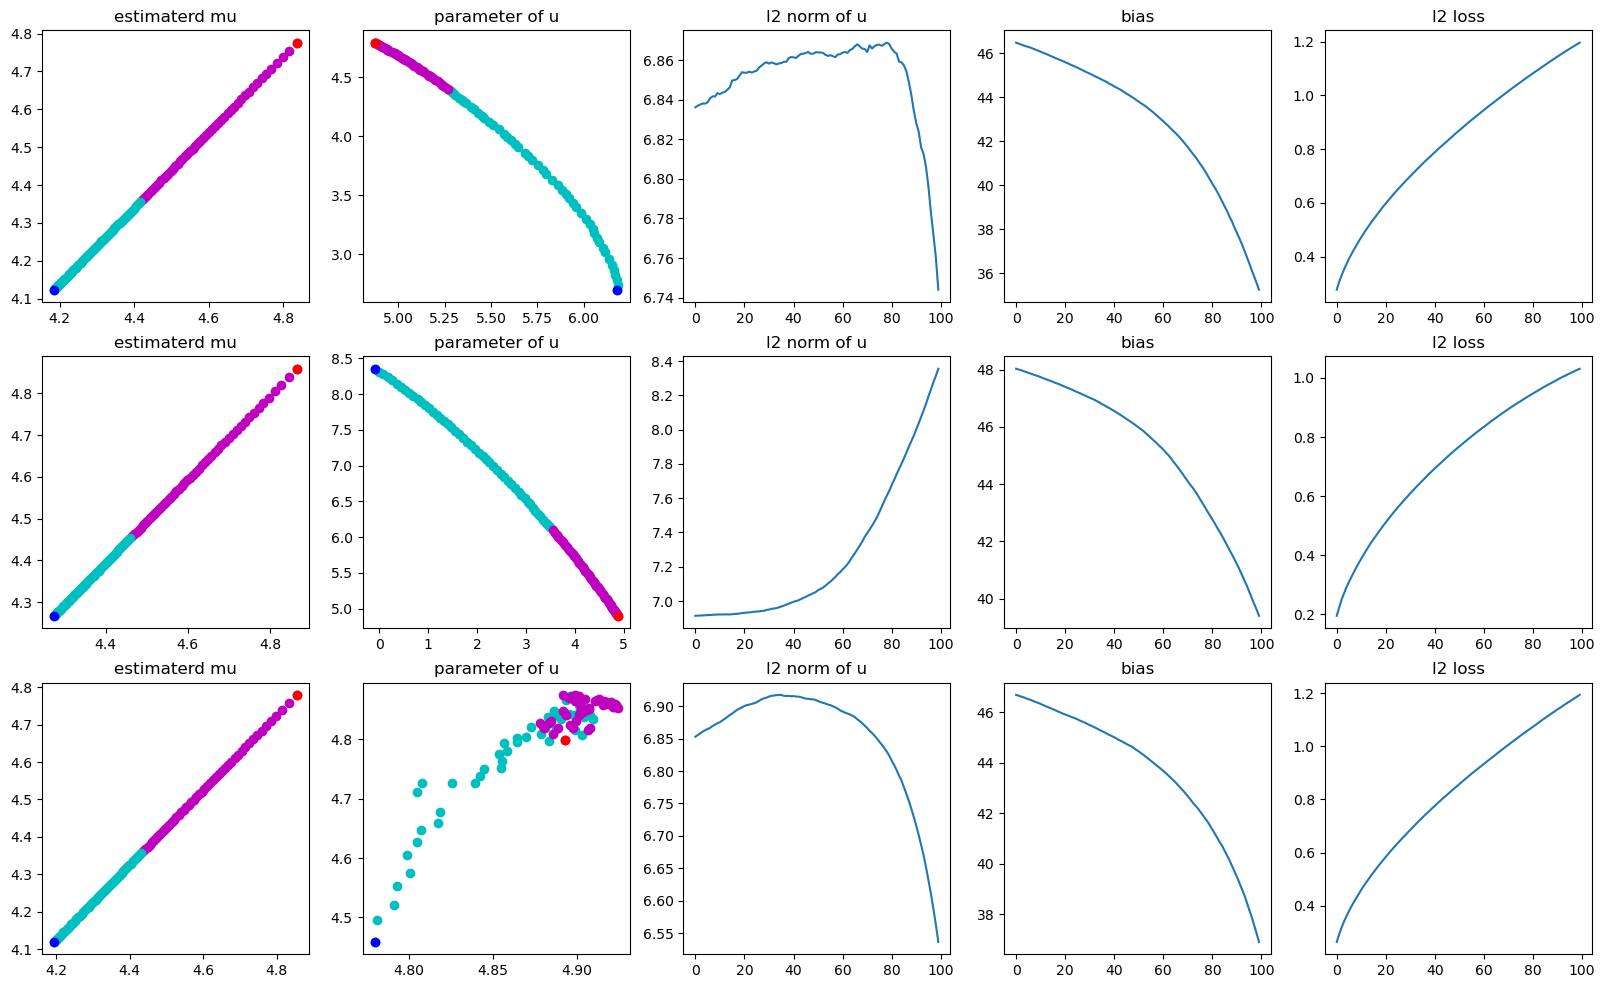

In [18]:
plot_2dim(res_mean, res_par, False)